[Day 0] POS: growCC=52, keptCC=24, all_kept_have_seed=True, bad=[]
[Day 0] NEG: growCC=60, keptCC=34, all_kept_have_seed=True, bad=[]


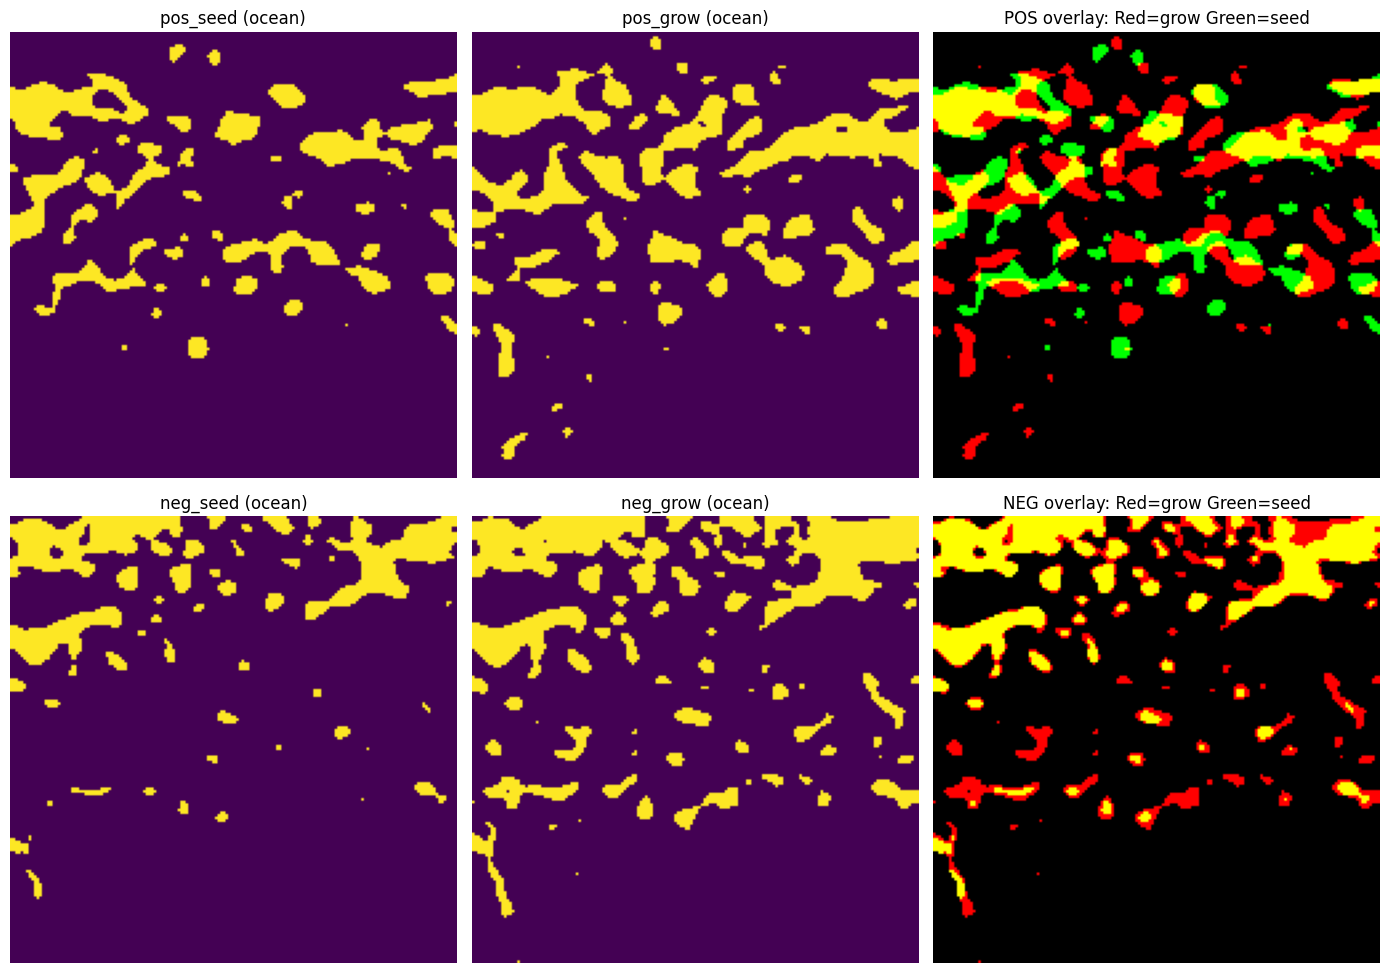

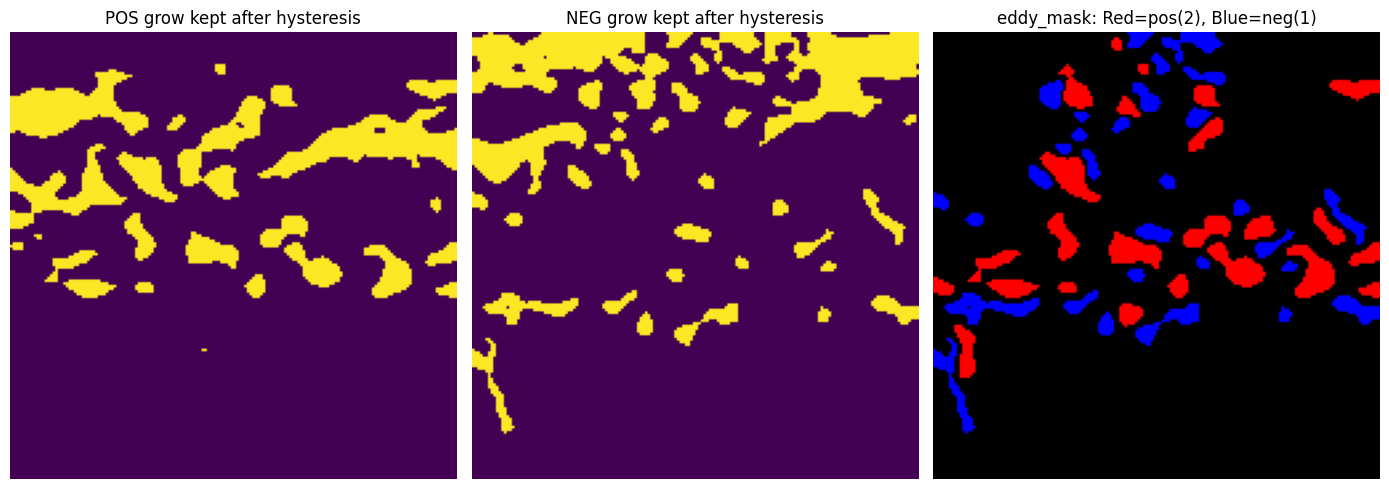

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects

DAY_IDX = 0  # 你要看的那一天索引

# 你的分文件 facts + mask
pos_seed_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_pos_seed_2000-2010.npy")
pos_grow_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_pos_grow_2011.npy")
neg_seed_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_neg_seed_2011.npy")
neg_grow_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_neg_grow_2011.npy")
ocean_all    = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_ocean_2011.npy")
eddy_mask_all= np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\eddy_mask_2011.npy")

def pick_day(arr, day_idx):
    return arr if arr.ndim == 2 else arr[day_idx]

# 兼容你的保存可能是 float32 的 0/1
pos_seed = (pick_day(pos_seed_all, DAY_IDX) > 0.5)
pos_grow = (pick_day(pos_grow_all, DAY_IDX) > 0.5)
neg_seed = (pick_day(neg_seed_all, DAY_IDX) > 0.5)
neg_grow = (pick_day(neg_grow_all, DAY_IDX) > 0.5)
ocean    = (pick_day(ocean_all, DAY_IDX) > 0.5)
eddy_mask= pick_day(eddy_mask_all, DAY_IDX)

# ===== hysteresis（严格按你 Step1_compute_eddy_mask.py 的做法：8邻域）=====
def hysteresis_mask(grow: np.ndarray, seed: np.ndarray, ocean: np.ndarray):
    structure = np.ones((3, 3), dtype=int)
    lab, n = label((grow & ocean).astype(np.uint8), structure=structure)
    out = np.zeros_like(grow, dtype=bool)
    if n == 0:
        return out, lab, 0

    slices = find_objects(lab)
    for comp_id, sl in enumerate(slices, start=1):
        if sl is None:
            continue
        region = (lab[sl] == comp_id)
        # 必须含 seed
        if not np.any(seed[sl] & region):
            continue
        out[sl][region] = True
    return out, lab, n

def check_each_kept_component_has_seed(seed_mask, kept_mask):
    structure = np.ones((3, 3), dtype=int)
    lab, n = label(kept_mask.astype(np.uint8), structure=structure)
    bad = []
    for cid in range(1, n + 1):
        comp = (lab == cid)
        if not np.any(seed_mask & comp):
            bad.append(cid)
    return (len(bad) == 0), n, bad

pos_keep, _, pos_grow_cc = hysteresis_mask(pos_grow, pos_seed, ocean)
neg_keep, _, neg_grow_cc = hysteresis_mask(neg_grow, neg_seed, ocean)

pos_ok, pos_keep_cc, pos_bad = check_each_kept_component_has_seed(pos_seed, pos_keep)
neg_ok, neg_keep_cc, neg_bad = check_each_kept_component_has_seed(neg_seed, neg_keep)

print(f"[Day {DAY_IDX}] POS: growCC={pos_grow_cc}, keptCC={pos_keep_cc}, all_kept_have_seed={pos_ok}, bad={pos_bad}")
print(f"[Day {DAY_IDX}] NEG: growCC={neg_grow_cc}, keptCC={neg_keep_cc}, all_kept_have_seed={neg_ok}, bad={neg_bad}")

# ===== overlay：红=grow，绿=seed =====
def overlay_seed_grow(seed, grow):
    out = np.zeros((*grow.shape, 3), dtype=np.float32)
    out[..., 0] = grow.astype(np.float32)
    out[..., 1] = seed.astype(np.float32)
    return out

# eddy_mask 编码：1=neg, 2=pos（按你的生成脚本）
mask_neg = (eddy_mask == 1)
mask_pos = (eddy_mask == 2)

# ===== 图 1：seed/grow + overlay（pos/neg）=====
plt.figure(figsize=(14, 10))

ax = plt.subplot(2, 3, 1); ax.imshow(pos_seed & ocean); ax.set_title("pos_seed (ocean)"); ax.axis("off")
ax = plt.subplot(2, 3, 2); ax.imshow(pos_grow & ocean); ax.set_title("pos_grow (ocean)"); ax.axis("off")
ax = plt.subplot(2, 3, 3); ax.imshow(overlay_seed_grow(pos_seed & ocean, pos_grow & ocean)); ax.set_title("POS overlay: Red=grow Green=seed"); ax.axis("off")

ax = plt.subplot(2, 3, 4); ax.imshow(neg_seed & ocean); ax.set_title("neg_seed (ocean)"); ax.axis("off")
ax = plt.subplot(2, 3, 5); ax.imshow(neg_grow & ocean); ax.set_title("neg_grow (ocean)"); ax.axis("off")
ax = plt.subplot(2, 3, 6); ax.imshow(overlay_seed_grow(neg_seed & ocean, neg_grow & ocean)); ax.set_title("NEG overlay: Red=grow Green=seed"); ax.axis("off")

plt.tight_layout()
plt.show()

# ===== 图 2：hysteresis 后的 grow + 最终 mask 对照 =====
plt.figure(figsize=(14, 8))

ax = plt.subplot(1, 3, 1); ax.imshow(pos_keep & ocean); ax.set_title("POS grow kept after hysteresis"); ax.axis("off")
ax = plt.subplot(1, 3, 2); ax.imshow(neg_keep & ocean); ax.set_title("NEG grow kept after hysteresis"); ax.axis("off")

# 为了对照更清楚：把 pos/neg 分开画成 RGB（红=pos(2), 蓝=neg(1)）
rgb = np.zeros((*ocean.shape, 3), dtype=np.float32)
rgb[..., 0] = (mask_pos & ocean).astype(np.float32)  # red: pos
rgb[..., 2] = (mask_neg & ocean).astype(np.float32)  # blue: neg
ax = plt.subplot(1, 3, 3); ax.imshow(rgb); ax.set_title("eddy_mask: Red=pos(2), Blue=neg(1)"); ax.axis("off")

plt.tight_layout()
plt.show()


[Day 0] IoU NEG: 1.0000, IoU POS: 0.6965


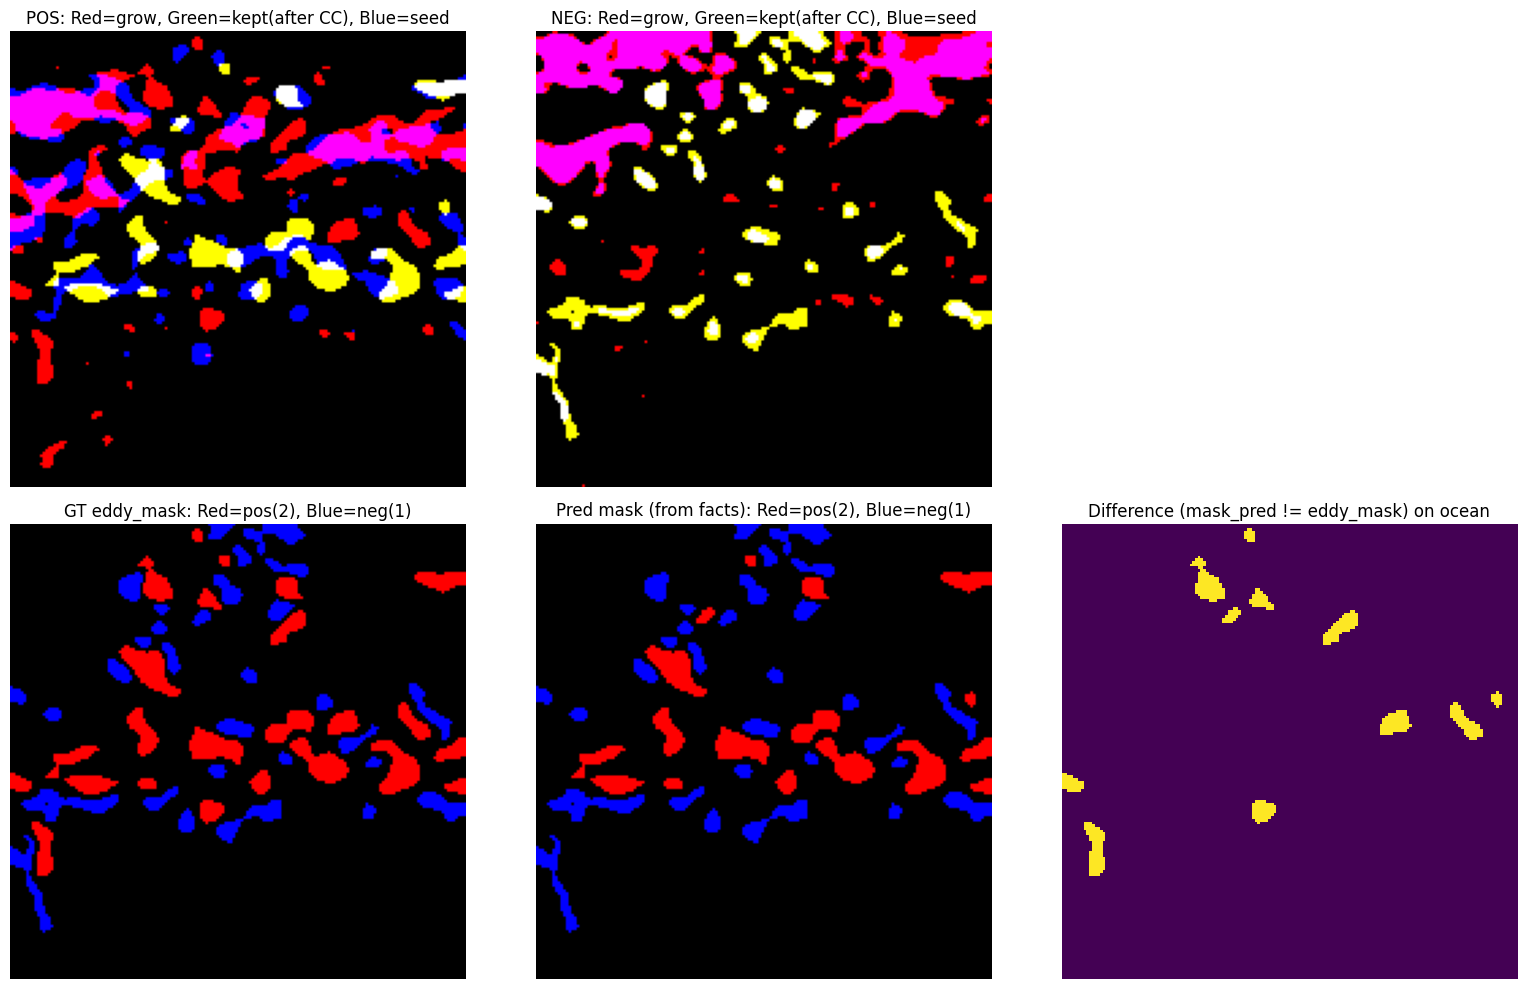

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects

DAY_IDX = 0

# ===== 读取你现在的 facts/mask =====
# 你的分文件 facts + mask
pos_seed_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_pos_seed_2000-2010.npy")
pos_grow_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_pos_grow_2011.npy")
neg_seed_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_neg_seed_2011.npy")
neg_grow_all = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_neg_grow_2011.npy")
ocean_all    = np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\facts\\facts_ocean_2011.npy")
eddy_mask_all= np.load("D:\\Desktop\\Neural Symbolic\\Code\\GITCode\\EddyNN-DeepProblog\\data\\eddy_mask_2011.npy")

def pick_day(arr, day_idx):
    return arr if arr.ndim == 2 else arr[day_idx]

pos_seed = (pick_day(pos_seed_all, DAY_IDX) > 0.5)
pos_grow = (pick_day(pos_grow_all, DAY_IDX) > 0.5)
neg_seed = (pick_day(neg_seed_all, DAY_IDX) > 0.5)
neg_grow = (pick_day(neg_grow_all, DAY_IDX) > 0.5)
ocean    = (pick_day(ocean_all, DAY_IDX) > 0.5)
eddy_mask= pick_day(eddy_mask_all, DAY_IDX)

# ===== hysteresis：保留“grow 连通域里含 seed”的部分（8邻域）=====
def hysteresis_mask(grow, seed, ocean):
    structure = np.ones((3,3), dtype=int)
    lab, n = label((grow & ocean).astype(np.uint8), structure=structure)
    out = np.zeros_like(grow, dtype=bool)
    if n == 0:
        return out
    slices = find_objects(lab)
    for comp_id, sl in enumerate(slices, start=1):
        if sl is None: 
            continue
        region = (lab[sl] == comp_id)
        if np.any(seed[sl] & region):  # 含 seed 才保留
            out[sl][region] = True
    return out

# ===== CC 面积过滤：只保留面积在 [min_area, max_area] 的连通域 =====
def cc_area_filter(mask, min_area=15, max_area=400):
    structure = np.ones((3,3), dtype=int)
    lab, n = label(mask.astype(np.uint8), structure=structure)
    out = np.zeros_like(mask, dtype=bool)
    if n == 0:
        return out
    slices = find_objects(lab)
    for comp_id, sl in enumerate(slices, start=1):
        if sl is None:
            continue
        region = (lab[sl] == comp_id)
        area = int(region.sum())
        if min_area <= area <= max_area:
            out[sl][region] = True
    return out

# ===== 应用规则（与你 Step1_compute_eddy_mask.py 一致的逻辑顺序）=====
pos_keep = hysteresis_mask(pos_grow, pos_seed, ocean)
neg_keep = hysteresis_mask(neg_grow, neg_seed, ocean)

# 如果你 Step1 里 INCLUDE_CC=True，就打开下面两行（面积过滤）
pos_keep_cc = cc_area_filter(pos_keep, min_area=15, max_area=400)
neg_keep_cc = cc_area_filter(neg_keep, min_area=15, max_area=400)

# ===== 合成最终 mask_pred：注意你规则里是 1=neg, 2=pos 且 pos 覆盖 neg =====
mask_pred = np.zeros_like(eddy_mask, dtype=np.uint8)
mask_pred[neg_keep_cc] = 1
mask_pred[pos_keep_cc] = 2

# ===== 计算 IoU（分别对 pos/neg）=====
def iou(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / (union + 1e-9)

gt_neg = (eddy_mask == 1)
gt_pos = (eddy_mask == 2)
pd_neg = (mask_pred == 1)
pd_pos = (mask_pred == 2)

print(f"[Day {DAY_IDX}] IoU NEG: {iou(gt_neg, pd_neg):.4f}, IoU POS: {iou(gt_pos, pd_pos):.4f}")

# ===== 可视化：1) grow vs keep  2) mask_pred vs gt =====
def overlay_three(grow, keep, seed):
    # 红：grow；绿：keep；蓝：seed（你也可以换配色）
    rgb = np.zeros((*grow.shape, 3), dtype=np.float32)
    rgb[..., 0] = grow.astype(np.float32)
    rgb[..., 1] = keep.astype(np.float32)
    rgb[..., 2] = seed.astype(np.float32)
    return rgb

plt.figure(figsize=(16, 10))

# POS: grow / keep / seed 三层叠加
ax = plt.subplot(2, 3, 1)
ax.imshow(overlay_three(pos_grow & ocean, pos_keep_cc & ocean, pos_seed & ocean))
ax.set_title("POS: Red=grow, Green=kept(after CC), Blue=seed")
ax.axis("off")

# NEG
ax = plt.subplot(2, 3, 2)
ax.imshow(overlay_three(neg_grow & ocean, neg_keep_cc & ocean, neg_seed & ocean))
ax.set_title("NEG: Red=grow, Green=kept(after CC), Blue=seed")
ax.axis("off")

# 规则生成的 gt mask（红=pos(2)，蓝=neg(1)）
rgb_gt = np.zeros((*ocean.shape, 3), dtype=np.float32)
rgb_gt[..., 0] = ((eddy_mask == 2) & ocean).astype(np.float32)
rgb_gt[..., 2] = ((eddy_mask == 1) & ocean).astype(np.float32)
ax = plt.subplot(2, 3, 4)
ax.imshow(rgb_gt)
ax.set_title("GT eddy_mask: Red=pos(2), Blue=neg(1)")
ax.axis("off")

# 你复现得到的 mask_pred（红=pos(2)，蓝=neg(1)）
rgb_pd = np.zeros((*ocean.shape, 3), dtype=np.float32)
rgb_pd[..., 0] = ((mask_pred == 2) & ocean).astype(np.float32)
rgb_pd[..., 2] = ((mask_pred == 1) & ocean).astype(np.float32)
ax = plt.subplot(2, 3, 5)
ax.imshow(rgb_pd)
ax.set_title("Pred mask (from facts): Red=pos(2), Blue=neg(1)")
ax.axis("off")

# 差异图：哪里不一样（白色=不一致）
diff = ((mask_pred != eddy_mask) & ocean)
ax = plt.subplot(2, 3, 6)
ax.imshow(diff, interpolation="nearest")
ax.set_title("Difference (mask_pred != eddy_mask) on ocean")
ax.axis("off")

plt.tight_layout()
plt.show()
